In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

warnings.filterwarnings("ignore")

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, silent=False)
filt_na(univ)

Setup R3000 universe
use existing binary file
0.596001 seconds


In [3]:
from factor_mining.factors.momentum import momentum, momentum_ewma
from factor_mining.factors.momentum_gap import momentum_gap
from factor_mining.factors.revised_momentum import revised_momentum

In [6]:
%%time
# construct all variants
univ_table = stack(univ)
# univ_table.date = pd.to_datetime(univ_table.date)

head, tail = 4, 52
factors = {}
factors['momentum_ewma'] = momentum_ewma(univ_table, head, tail, halflife=13)

CPU times: user 16.9 s, sys: 16 ms, total: 16.9 s
Wall time: 16.9 s


In [7]:
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the illiquid names within universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'volume', 1500000)
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Scale each factor
Winsorize with +/- 3 std
Done


In [8]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = datetime(2012, 1, 1)
end_date = datetime(2016, 12, 31)

2010-04-30 00:00:00 2017-04-28 00:00:00


In [9]:
%%time
from itertools import product
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [start_date, end_date]
config_iter = product(factor_names, ranges)
iter_result = {}
for f, g in config_iter:
    print(f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
    ptfl_lst, pnl_lst = bt.calc_pnl()
    k = f + '_' + str(g[0]) + '_' + str(g[1])
    iter_result[k] = (np.nanmean(pnl_lst.pnl), np.sqrt(np.nanvar(pnl_lst.pnl)))

momentum_ewma [0, 5]
momentum_ewma [5, 10]
momentum_ewma [10, 15]
momentum_ewma [15, 20]
momentum_ewma [20, 25]
momentum_ewma [25, 30]
momentum_ewma [30, 35]
momentum_ewma [35, 40]
momentum_ewma [40, 45]
momentum_ewma [45, 50]
momentum_ewma [50, 55]
momentum_ewma [55, 60]
momentum_ewma [60, 65]
momentum_ewma [65, 70]
momentum_ewma [70, 75]
momentum_ewma [75, 80]
momentum_ewma [80, 85]
momentum_ewma [85, 90]
momentum_ewma [90, 95]
momentum_ewma [95, 100]
CPU times: user 9min 28s, sys: 88 ms, total: 9min 28s
Wall time: 9min 28s


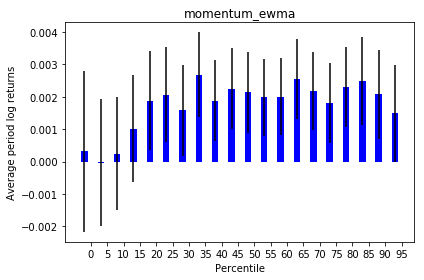

In [10]:
for n in factor_names:
    c = len(pnl_lst)
    x = [5*i for i in range(20)]
    y = [iter_result[n+'_'+str(i)+'_'+str(i+5)][0] for i in x]
    s = [iter_result[n+'_'+str(i)+'_'+str(i+5)][1] / np.sqrt(c) for i in x]
    
    # Here comes the plots
    bar_width = 2
    week = plt.bar(np.array(x), y, width=bar_width, yerr=s, color='b')

    plt.xlabel('Percentile')
    plt.ylabel('Average period log returns')
    plt.title(n)
    plt.xticks(np.array(x) + bar_width, x)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
spcalc = PercentilePtflSpcalc(signal='momentum_ewma', sel_range=[90, 100])
bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()
bt.calc_pa()

CAGR :	 0.0981561117515
Volatility :	 0.16051795765
Sharpe :	 0.583314867892
Max_Drawdown :	 0.311219833426
Drawdown_Length :	 2


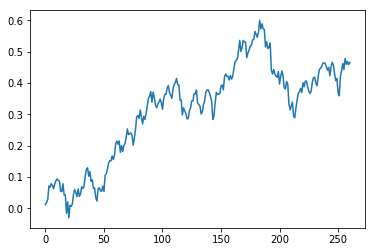

In [15]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()